<a href="https://colab.research.google.com/github/jaydenchoe/Fundamentals-of-Deep-Learning-Book/blob/master/ch09_models_for_sequence_analysis/Ch09_04_Dissecting_NTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Preparation
First, you'll need to download the Spacy NLP library. Run the next cell to install Spacy, then **RESTART the COLAB RUNTIME by clicking on the menu Runtime - Restart runtime.**

In [ ]:
# 2025-0901 added for version issues
!pip uninstall -y -q torchtune
!pip install -q torch==2.3.0 torchtext==0.18.0 torchdata==0.8.0 "portalocker>=2.0.0"

# Download Spacy tokenizers
#!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

# Need to restart Colab Runtime
# 설치 반영 위해 런타임 자동 재시작됩니다(필수). 이후에는 다음 셀부터 실행하면 됩니다.
import os
os.kill(os.getpid(), 9)

ERROR: Could not find a version that satisfies the requirement torch==2.1.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==2.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 88.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You ca

# Restart Colab Runtime
Click menu Runtime - Restart runtime

# IWSLT2016 Dataset

In [1]:
import torch, torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import IWSLT2016
from typing import Iterable, List
import numpy as np

print(f"PyTorch Version: {torch.__version__}")
print(f"TorchText Version: {torchtext.__version__}")

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

PyTorch Version: 2.3.0+cu121
TorchText Version: 0.18.0+cpu


# ERROR ALERT:
*   You may receive a **"RuntimeError: Internal error: confirm_token was not found in Google drive link."** in the cell below.
*   This is a recent error in Torchtext 0.11.0 due to the dataset URL changing and/or changes to requests library.
* We are trying to find a workaround.


# Code that follows remains for illustrative purposes.

In [6]:
import spacy
from torchtext.data.utils import get_tokenizer
from datasets import load_dataset

# --- 2. 'datasets' 라이브러리로 안정적인 데이터 로드 ---
# 로그인이나 깨진 URL 걱정 없이 'opus_books' 공개 데이터셋을 바로 불러옵니다.
print("데이터셋 로딩 중...")
raw_datasets = load_dataset("opus_books", "en-fr", split='train')
print("데이터셋 로딩 완료.")

# --- 3. 기존 코드와 호환되는 'train_iter' 생성 ---
# 기존 for문이 (영어 문장, 프랑스어 문장) 쌍을 기대하므로, 형식을 맞춰줍니다.
def data_iterator():
    for example in raw_datasets:
        yield (example['translation']['en'], example['translation']['fr'])

train_iter = data_iterator()

필수 라이브러리 설치 완료.
데이터셋 로딩 중...


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

데이터셋 로딩 완료.


# WARNING:
If you get an error running the next cell, it's probably because you didn't restart the runtime in step 1.

In [2]:
train_iter = IWSLT2016(split=('train'),
                       language_pair=('en','fr'))

/usr/local/lib/python3.12/dist-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [7]:
tokenizer_en = get_tokenizer('spacy',language='en_core_web_sm')
tokenizer_fr = get_tokenizer('spacy',language='fr_core_news_sm')

In [9]:
%%time
sent_len_en = []
sent_len_fr = []
iter_len = 0
for en_sent, fr_sent in train_iter:
  sent_len_en.append(len(tokenizer_en(en_sent)))
  sent_len_fr.append(len(tokenizer_fr(fr_sent)))
  iter_len += 1
print(f'Dataset contains {iter_len} sentences.')


Dataset contains 127085 sentences.
CPU times: user 1min 28s, sys: 137 ms, total: 1min 29s
Wall time: 1min 32s


## Check sentence lengths in dataset
Are the buckets sizes good?

In [10]:
bucket_sizes = [(5, 10), (10, 15), (20, 25), (40, 50)]

1 488
1 433


(array([21883., 38331., 27891., 16807.,  9641.,  5177.,  2818.,  1651.,
          966.,   683.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

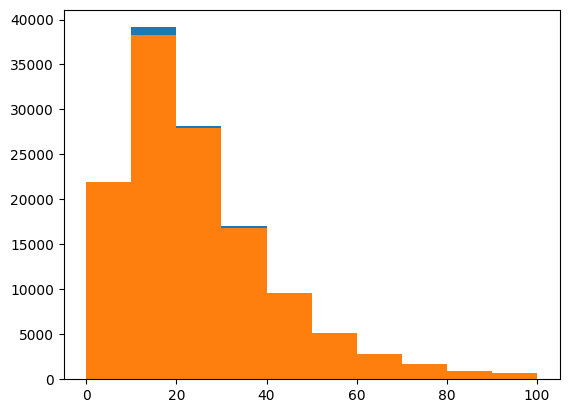

In [11]:
import matplotlib.pyplot as plt
print(np.array(sent_len_en).min(), np.array(sent_len_en).max())
plt.hist(sent_len_en, range=(0,100))

print(np.array(sent_len_fr).min(), np.array(sent_len_fr).max())
plt.figure
plt.hist(sent_len_fr, range=(0,100))

# Create Vocabularies (en, fr)

In [13]:
from torchtext.vocab import build_vocab_from_iterator
from datasets import load_dataset

# --- 1. 이전 단계에서 정의했던 데이터 로더 함수를 다시 사용 ---
# (이 함수는 실행할 때마다 데이터셋을 처음부터 다시 읽어주는 생성기입니다)
def data_iterator():
    raw_datasets = load_dataset("opus_books", "en-fr", split='train')
    for example in raw_datasets:
        yield (example['translation']['en'], example['translation']['fr'])

# --- 2. 기존 코드의 로직 (수정 거의 없음) ---
# 이 로직은 원래 코드와 동일합니다.
def yield_tokens(data_iter, language_index):
    # 영어는 0번 인덱스, 프랑스어는 1번 인덱스
    for data_sample in data_iter:
        yield tokenizer_en(data_sample[language_index]) if language_index == 0 else tokenizer_fr(data_sample[language_index])

UNK_IDX, PAD_IDX, GO_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<go>', '<eos>']

# --- 3. 단어장 생성 (IWSLT2016 대신 data_iterator() 사용) ---
print("영어 단어장 생성 중...")
# data_iterator()를 호출하여 영어용 데이터 스트림 생성
train_iter_en = data_iterator()
vocab_en = build_vocab_from_iterator(
                  yield_tokens(train_iter_en, 0), # 영어 인덱스 0
                  min_freq=1,
                  specials=special_symbols,
                  special_first=True)
vocab_en.set_default_index(UNK_IDX)
print("영어 단어장 생성 완료.")


print("프랑스어 단어장 생성 중...")
# data_iterator()를 다시 호출하여 프랑스어용 데이터 스트림 생성
train_iter_fr = data_iterator()
vocab_fr = build_vocab_from_iterator(
                  yield_tokens(train_iter_fr, 1), # 프랑스어 인덱스 1
                  min_freq=1,
                  specials=special_symbols,
                  special_first=True)
vocab_fr.set_default_index(UNK_IDX)
print("프랑스어 단어장 생성 완료.")


# --- 4. 결과 확인 ---
print(f"\n영어 단어장 크기: {len(vocab_en)}")
print(f"프랑스어 단어장 크기: {len(vocab_fr)}")

영어 단어장 생성 중...
영어 단어장 생성 완료.
프랑스어 단어장 생성 중...
프랑스어 단어장 생성 완료.

영어 단어장 크기: 66389
프랑스어 단어장 크기: 77676


In [14]:
print(len(vocab_en), len(vocab_fr))

66389 77676


# Preprocess Data

In [15]:
# Token processing:
#   source: pad and reverse
#   target: add GO, EOS, and pad

def process_tokens(source, target, bucket_sizes):
  # find bucket_index
  for i in range(len(bucket_sizes)+2):
    # truncate if we exhauset list of buckets
    if i >= len(bucket_sizes):
      bucket = bucket_sizes[i-1]
      bucket_id = i-1
      if len(source) > bucket[0]:
        source = source[:bucket[0]]
      if len(target) > (bucket[1]-2):
        target = target[:bucket[1]-2]
      break

    bucket = bucket_sizes[i]
    if (len(source) < bucket[0]) and ((len(target)+1) < bucket[1]):
      bucket_id = i
      break

  source += ((bucket_sizes[bucket_id][0] - len(source)) * ['<pad>'])
  source = list(reversed(source))

  target.insert(0,'<go>')
  target.append('<eos>')
  target += (bucket_sizes[bucket_id][1] - len(target)) * ['<pad>']

  return vocab_en(source), vocab_fr(target), bucket_id

  # source_t = torch.tensor(vocab_en(source), dtype=torch.float32)
  # target_t = torch.tensor(vocab_fr(target), dtype=torch.float32)
  # return source_t, target_t, bucket_id

In [17]:
# 1. IWSLT2016(...) 대신, 우리가 만든 data_iterator()를 사용합니다.
train_iter = data_iterator()

# 2. 나머지 코드는 그대로 사용합니다.
for sent_en, sent_fr  in train_iter:
  # 이 코드가 작동하려면 process_tokens 함수와 bucket_sizes 변수가
  # 노트북의 위쪽 셀 어딘가에 미리 정의되어 있어야 합니다.
  source, target, bucket_id = process_tokens(tokenizer_en(sent_en),
                                          tokenizer_fr(sent_fr),
                                          bucket_sizes)
  print(bucket_id, bucket_sizes[bucket_id])
  print(len(source), source)
  print(len(target),target)

  break

0 (5, 10)
5 [1, 1, 1, 45530, 45]
10 [2, 84, 177, 776, 3, 1, 1, 1, 1, 1]


In [18]:
def create_bucketed_datasets(data_iter, bucket_sizes, max_data_size=None):
  datasets = []
  for i in range(len(bucket_sizes)):
    datasets.append([])

  iter_len = 0
  for sent_en, sent_fr  in train_iter:
    source, target, bucket_id = process_tokens(tokenizer_en(sent_en),
                                    tokenizer_fr(sent_fr),
                                    bucket_sizes)
    datasets[bucket_id].append((source, target))
    iter_len += 1
    if max_data_size != None and iter_len > max_data_size:
      break
    #break
  print(f'Dataset contains {iter_len} sentences.')
  return datasets

In [20]:
# 1. IWSLT2016(...) 대신, 우리가 만든 data_iterator()를 사용합니다.
train_iter = data_iterator()

# 2. 나머지 코드는 그대로 사용합니다.
# 이 코드가 작동하려면 create_bucketed_datasets 함수와 bucket_sizes 변수가
# 노트북의 위쪽 셀 어딘가에 미리 정의되어 있어야 합니다.
datasets = create_bucketed_datasets(train_iter, bucket_sizes)

print("데이터셋 버킷 생성 완료!")

Dataset contains 127085 sentences.
데이터셋 버킷 생성 완료!


In [21]:
for dataset in datasets:
  print(len(dataset), len(dataset[0][0]), len(dataset[0][1]))
datasets[0][0][1] # dataset, sample, token_list

3275 5 10
17317 10 15
38443 20 25
68050 40 50


[2, 84, 177, 776, 3, 1, 1, 1, 1, 1]

# Create Dataloaders for batching

In [22]:
# When we get a batch, the data should be same bucket size
# Create separate Map-Style datasets based on bucket size
# Each dataset will have a separate Dataloader
from torch.utils.data import Dataset

class BucketedDataset(Dataset):
  def __init__(self, bucketed_dataset, bucket_size):
    super(BucketedDataset, self).__init__()
    self.length = len(bucketed_dataset)
    self.input_len = bucket_size[0]
    self.target_len = bucket_size[1]
    self.bucketed_dataset = bucketed_dataset

  def __getitem__(self, index):
    return (torch.tensor(self.bucketed_dataset[index][0],
                         dtype=torch.float32),
            torch.tensor(self.bucketed_dataset[index][1],
                         dtype=torch.float32))

  def __len__(self):
    return self.length


In [23]:
bucketed_datasets = []
for i, dataset in enumerate(datasets):
  bucketed_datasets.append(BucketedDataset(dataset,
                                           bucket_sizes[i]))
# for dataset in bucketed_datasets:
#   print(len(dataset))
#   print(dataset[0])

# Set up Dataloaders for batching

In [24]:
from torch.utils.data import DataLoader

In [25]:
dataloaders = []
for dataset in bucketed_datasets:
  dataloaders.append(DataLoader(dataset,
                                batch_size=32,
                                shuffle=True))

# Training

In [26]:
import torch.nn as nn

class TranslateLSTM(nn.Module):
  def __init__(self):
    super(TranslateLSTM, self).__init__()
    self.layer = nn.Linear(10,1)

  def forward(self, x):
    return self.layer(x)

In [27]:
import torch.nn as nn
import torch.optim as optim

model = TranslateLSTM()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train(source, target):
  optimizer.zero_grad()
  outputs = model(inputs)
  loss = loss_fn(outputs, inputs)
  loss.backward()
  optimizer.step()

  return loss, output

In [33]:
# 모델 구조 확인 코드
print("모델 구조:")
print(model)

print("\nOptimizer:", optimizer.__class__.__name__)
print("Loss function:", loss_fn.__class__.__name__)

# 파라미터 수 간단 확인
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,} (trainable: {trainable_params:,})")

모델 구조:
Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=3, bias=True)
)

Optimizer: Adam
Loss function: CrossEntropyLoss

Total parameters: 643 (trainable: 643)
